分层风险平价是基于多因子协方差矩阵和由此导出的标的协方差矩阵的分散化资产配置模型。
相较于传统的二次优化器，其最大的优势在于解决了：Instability（对预测收益率参数的敏感度）, concentration（标的配置的集中）, underperformance（最终效果甚至不如等权分配）
从算法层面来讲，传统资产配置中对协方差矩阵做逆变换这一步，其数学含义为在估计一对（pair）标的间的相关系数时遍历了整个信息域，导致很小的估计误差带来了配置方案的巨大差异，因此有必要将信息域中不必要的边drop掉，分层的树结构呼之欲出。
不仅是解决了传统优化算法的缺点，分层风险平价更是不惧病态协方差矩阵（无须可逆性和正定性），这是二次优化器做不到的。
Framwwork:
    Preprocessing on cov.related work
    Tree cluster
    Quasi-Diagonalization
    Recursive bisection
    Post numerical experiment
    Backtest on chinese stock market

本脚本为分层算法的BabyVersion，有助于理解远离

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import scipy.spatial.distance as ssd
import scipy.cluster.hierarchy as sch
import random

In [2]:
#Stage 1
def getIVP( cov , **kargs):
   
    # compute the inverse-variance portfolio
    ivp = 1 / np.diag(cov)   #ivp为一维数组
    ivp /= ivp.sum()
    return ivp               #最终方差大的部分ivp较小

def getClusterVar( cov,cItems ):
    #compute variance per cluster
    cov_ = cov.loc[ cItems,cItems ]  # matrix slice
    w_ = getIVP(cov_).reshape(-1,1)  #设定reshape后列数为1，行数-1代表自动匹配计算，w_为 X by 1 的风险分配权重
    cVar = np.dot( np.dot(w_.T, cov_),w_ )[0,0]   # 1byX * XbyX * Xby1
    return cVar

In [4]:
#Stage 2
def getQuasiDiag( link ):
    #执行Quasi-Diagonization的步骤，将因子暴露意义下相似的股票放到一起
    #sort clustered items by distance
    link = link.astype(int) #returns a copy of the array converted to the specified type
    #sortIx记录每一层的组分
    sortIx = pd.Series( [link[-1,0] , link[-1,1]] )
    numItems = link[-1,3]    # number of original items,最后一行为root
    while sortIx.max() >= numItems:
        sortIx.index = range(0 , sortIx.shape[0]*2 , 2)  #make space, step_length = 2
        df0 = sortIx[ sortIx>=numItems ]                 #find clusters，把代表cluster而非originalelement的取出来
        i = df0.index; j = df0.values - numItems
        sortIx[i] = link[j,0]     #item 1
        df0 = pd.Series( link[j,1] , index=i+1)  #循环变量在这里结束时+1
        sortIx = sortIx.append(df0)  #item 2
        sortIx = sortIx.sort_index()  #re-sort
        sortIx.index = range( sortIx.shape[0] ) #re-index
    return sortIx.tolist()

In [5]:
#Stage 3
def getRecBipart( cov, sortIx ):
    # Bottom-up: Define the variance of a continuous subset as the variance of an inverse-variance allocation
    # Top-down: Split allocations btw adjacent subsets in inverse proportion to their aggregated variances
    w = pd.Series(1 , index=sortIx)
    cItems = [sortIx]     #initialize all items in one cluster
    while len(cItems)>0:
        cItems = [ i[j:k] for i in cItems for j,k in ( (0,len(i)//2),(len(i)//2,len(i)) ) if len(i)>1 ]
        # above: bi-section
        for i in range(0, len(cItems), 2):    #parse in pairs
            cItems0 = cItems[i]   #cluster 1
            cItems1 = cItems[i+1] #cluster 2
            cVar0 = getClusterVar( cov,cItems0)
            cVar1 = getClusterVar( cov,cItems1)
            alpha = 1 - cVar0/(cVar0+cVar1)
            w[cItems0] *= alpha    #weight1
            w[cItems1] *= 1-alpha  #weight2
        
    return w   #返回最终标的权重Series

In [6]:
#Stage 0
def correlDist(corr):
    # Output a distance matrix based on correlation, where 0<= d[i,j] <=1
    #合理的距离测度，针对于由相关性定义的原始距离矩阵
    dist = ( (1-corr)/2. )**.5
    return dist

def CalEucliDist(vec1,vec2):  
    #Output euclidean distance
    #vec1,vec2分别为两个np.array
    eucli = np.sqrt( np.sum( np.square(vec1 - vec2) ) )  
    return eucli 

def correlDist_ofDist1(dist):
    # A distance matrix based on original dist matrix
    # Compute the Euclidean distance btw any two col-vectors of dist
    # Therefore, new mat is a distance defined over the ENTIRE metric space,\
    # Rather than a PARTICULAR cross-correlation pair!
    dist_ofDist = np.empty( shape(dist) )
    
    for i in range( 0,shape(dist)(1) ):
        for j in range( i+1,shape(dist)(1) ):
            dist_ofDist[i,j] = CalEucliDist( dist[:,i],dist[:,j] )
            dist_ofDist[j,i] = dist_ofDist[i,j]
            
    dist_ofDist = ssd.squareform(dist_ofDist)
    return dist_ofDist  # 转换为CondensedForm的

#Otherwise, 可以调用scipy包中高维空间距离矩阵的算法
def correlDist_ofDist2(dist):
    dist_ofDist = ssd.pdist( dist, 'euclidean' )  #返回CondensedForm，即只有上三角部分存成数组形式
    
    return dist_ofDist  # CondensedForm的

In [7]:
def plotCorrMatrix( path, corr, labels=None):
    # Heatmapping of the corr matri
    if labels is None: labels = []
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks( np.arange(.5 , corr.shape[0]+.5) , labels )
    mpl.xticks( np.arange(.5 , corr.shape[0]+.5) , labels )
    mpl.savefig(path)
    mpl.clf(); mpl.close()   # reset pylab
    return

In [8]:
def plotLink(link):
    #calculate all dendrogram
    mpl.figure(figsize = (25,10))
    mpl.title('Clustering Dendrogram')
    mpl.xlabel('saplte index')
    mpl.ylabel('distance')
    sch.dendrogram(
        link,
        leaf_rotation = 90. ,# rotates the x axis labels
        leaf_font_size = 12. , #font size for the x axis labels
    )
    mpl.show()

In [9]:
def generateData( nObs, size0 ,size1 ,sigma1):
    # Time series of correlated variables
    # UNcorrelated Data
    np.random.seed(seed=54321); random.seed(12345)
    x = np.random.normal( 0 ,1 , size=(nObs ,size0)) #each row is a variable
    # Creating correlation btw the variables
    #五条原始的独立序列，五条衍生出的相关序列
    cols = [ random.randint(0 , size0-1) for i in range(size1)]
    y = x[: , cols] + np.random.normal( 0 ,sigma1 ,size=(nObs , len(cols)))
    #再把衍生序列叠加到原始序列边上
    x = np.append(x ,y ,axis =1)
    x = pd.DataFrame( x, columns = range(1 ,x.shape[1]+1) )
    return x,cols

In [ ]:
def tail_ratio(returns):
    """Determines the ratiro btw the right95% and left5% tail
     Input:
     returns: pd.Series
          dailt returns of strategy, noncumulative
     Output:
     tail ratio describing how good or bad the relative tails will leads to
     """
    return np.abs(np.percentile(returns,95)) / np.abs(np.percentile(returns,5))

In [11]:
def main1():
    # 一、生成相关性时间序列
    nObs , size0 ,size1 , sigma1 = 10000, 5 , 5, .25
    x , cols = generateData( nObs, size0 ,size1 , sigma1)
    print( [ (j+1 , size0+i) for i,j in enumerate(cols,1) ] )
    
    return x

In [12]:
x = main1()

[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10)]


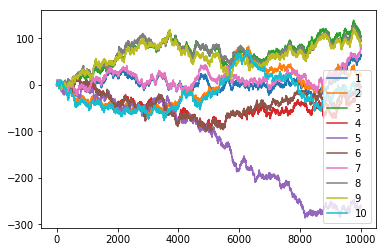

In [13]:
x.cumsum(0).plot()

In [14]:
def main2(x):
    #二、计算并画出相关矩阵
    cov , corr = x.cov() , x.corr()
    plotCorrMatrix('HRP3_corr0.png' , corr ,labels = corr.columns)
    
    return cov, corr

cov, corr = main2(x)

In [15]:
def main3(corr):
    #三、聚类
    dist = correlDist(corr)  #Output a original dist matrix
    
    dist = ssd.squareform(dist)  # Transformed into condensed form
    #new_dist = correlDist_ofDist2(dist)   #Output a manipulated dist matrix
    
    # Sure about the condensed form of input dist ???
    
    link = sch.linkage( dist , 'single' )  # 完成聚类工作。返回的link为 列数为4 的矩阵，每行元素分别为两个constituents,一个距离，一个类内元素数目
# Performs hierarchical/agglomerative clustering on the Condensed distance matrix y.
# linkage methods are used to compute the distance (d(s, t)) between two clusters (s) and (t).
# The algorithm begins with a forest of clusters that have yet to be used in the hierarchy being formed.
# When two clusters (s) and (t) from this forest are combined into a single cluster (u), (s) and (t) are removed from the forest, and (u) is added to the forest.
# When only one cluster remains in the forest, the algorithm stops, and this cluster becomes the root. (从分支逐渐回溯到根)
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()  #recover labels
    df0 = corr.loc[ sortIx , sortIx]      #reorder
    plotCorrMatrix('HRP3_corr1.png', df0 ,labels = df0.columns)

    return sortIx

sortIx = main3(corr)

In [16]:
sortIx    #这就是类对角化后的标的排序

[9, 3, 8, 1, 7, 2, 10, 5, 4, 6]

In [17]:
def main4(cov,sortIx):
    #四、资产配置
    hrp = getRecBipart(cov , sortIx)
    print ( hrp )
    return

main4(cov, sortIx)



9     1
3     1
8     1
1     1
7     1
2     1
10    1
5     1
4     1
6     1
dtype: int64


In [ ]:
def getHRP(cov, corr):
   
    #Construct a hierarchical portfolio
    corr,cov = pd.DataFrame(corr),pd.DataFrame(cov)
    dist = correlDist(corr)
    
    new_dist = correlDist_ofDist2(dist)
    
    link = sch.linkage(new_dist,'single')
    plotLink(link)
    
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    
    return hrp.sort_index()

In [29]:
def real_main():
    
    # 一、生成相关性时间序列
    nObs , size0 ,size1 , sigma1 = 10000, 5 , 5, .25
    x , cols = generateData( nObs, size0 ,size1 , sigma1)
    print( [ (j+1 , size0+i) for i,j in enumerate(cols,1) ] )
    
    #二、计算并画出相关矩阵
    cov , corr = x.cov() , x.corr()
    plotCorrMatrix('HRP3_corr0.png' , corr ,labels = corr.columns)
    
    #三、聚类
    dist = correlDist(corr)  #Output a original dist matrix
    
    dist = ssd.squareform(dist)  # Transformed into condensed form
    #new_dist = correlDist_ofDist2(dist)   #Output a manipulated dist matrix
    
    # Sure about the condensed form of input dist ???
    
    link = sch.linkage( dist , 'single' )  # 完成聚类工作。返回的link为 列数为4 的矩阵，每行元素分别为两个constituents,一个距离，一个类内元素数目
# Performs hierarchical/agglomerative clustering on the Condensed distance matrix y.
# linkage methods are used to compute the distance (d(s, t)) between two clusters (s) and (t).
# The algorithm begins with a forest of clusters that have yet to be used in the hierarchy being formed.
# When two clusters (s) and (t) from this forest are combined into a single cluster (u), (s) and (t) are removed from the forest, and (u) is added to the forest.
# When only one cluster remains in the forest, the algorithm stops, and this cluster becomes the root. (从分支逐渐回溯到根)
    
    plotLink(link)
    
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()  #recover labels
    df0 = corr.loc[ sortIx , sortIx]      #reorder
    plotCorrMatrix('HRP3_corr1.png', df0 ,labels = df0.columns)
    
    #四、资产配置
    hrp = getRecBipart(cov , sortIx)
    print ( len(hrp.sort_index()) )
    
    ivp = getIVP(cov)
    print(len(ivp))
    
    return
#-------------------------------------------------------------

#if _name_ == '_main_':main()

[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10)]


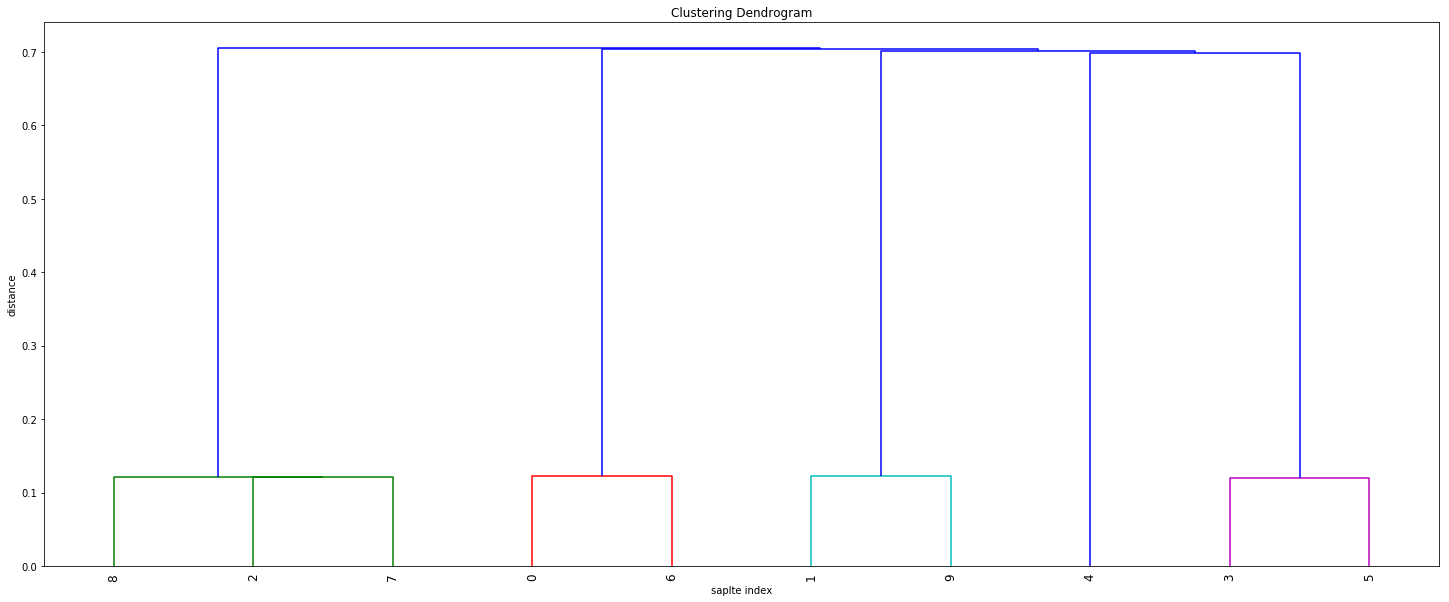

10
10


In [30]:
hrp_result = real_main()